## 1: Install Dependencies
This cell installs all necessary libraries for the application to run.

In [1]:
# -*- coding: utf-8 -*-
# Install all required libraries quietly
!pip install ipywidgets transformers torch sentencepiece huggingface_hub pypdf evaluate scikit-learn sentence-transformers matplotlib seaborn pandas nltk textstat rouge_score --quiet
# accelerate is needed for efficient multi-device model loading
!pip install accelerate --quiet
print("All dependencies installed successfully.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00
All dependencies installed successfully.


## 2: Import Libraries & Authenticate
This cell imports the required Python modules and securely logs into the Hugging Face Hub using your Colab secret.

In [2]:
import os
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata
from huggingface_hub import login
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import pypdf
import evaluate
import nltk
import io
import warnings
import time
import textstat
from math import pi

# --- 0. SETUP AND AUTHENTICATION ---
warnings.filterwarnings("ignore")

# CORRECTED: Download the 'punkt' resource and the specific 'punkt_tab' to fix the TextRank error
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True) # <-- This line explicitly fixes the error
except Exception as e:
    print(f"Error downloading NLTK data: {e}")

# Securely get the token from Colab secrets
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("Hugging Face Hub login successful.")
except Exception as e:
    print(f"🛑Hugging Face Hub login failed. Please ensure you have set the 'HF_TOKEN' secret correctly.")
    print(f"Error: {e}")

Hugging Face Hub login successful.


## 3: Load AI Models (Pre-computation)
This crucial, one-time step loads all the AI models into memory before any UI is displayed. This ensures the application is fast and responsive during use.

In [3]:
# --- 1. LOAD MODELS (PRE-COMPUTATION) ---
print("Loading small, fast models... This should be quicker now. ⏳")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model Dictionary to hold all loaded models
MODELS = {}

try:
    # Model 1: TinyLlama-1.1B-Chat (Open, 1.1B)
    model_id_tiny = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    MODELS['tinyllama'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_tiny),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_tiny,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        ),
        'name': "TinyLlama-1.1B-Chat"
    }
    print("✅ Loaded TinyLlama-1.1B-Chat.")

    # Model 2: Phi-1.5 (Restricted License, 1.3B)
    model_id_phi = "microsoft/phi-1.5"
    MODELS['phi'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_phi, trust_remote_code=True),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_phi,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        ),
        'name': "Phi-1.5"
    }
    print("✅ Loaded Phi-1.5.")

    # Model 3: BART (Public Baseline, ~400M)
    model_id_bart = "facebook/bart-large-cnn"
    MODELS['bart'] = {
        'summarizer': pipeline("summarization", model=model_id_bart, device=0 if device=="cuda" else -1),
        'name': 'BART-Large-CNN'
    }
    print("✅ Loaded BART-Large-CNN.")

    # Model 4: Gemma-2B-IT (Google)
    print("Loading Gemma-2B-IT... ⏳")
    model_id_gemma = "google/gemma-2b-it"
    MODELS['gemma'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_gemma, token=HF_TOKEN),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_gemma,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            token=HF_TOKEN
        ),
        'name': "Gemma-2B-IT"
    }
    print("✅ Loaded Gemma-2B-IT.")


    # Model 5: Sentence Transformer (for Extractive Baseline)
    MODELS['embedding'] = {
        'model': SentenceTransformer('all-MiniLM-L6-v2', device=device),
        'name': 'TextRank (Embeddings)'
    }
    print("✅ Loaded Sentence Transformer for TextRank.")

    print("\n🎉 All models loaded successfully!")
except Exception as e:
    print(f"🛑 Error loading models: {e}. Please check your token and model access permissions.")
    exit()

rouge_metric = evaluate.load("rouge")

Loading small, fast models... This should be quicker now. ⏳
Using device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Loaded TinyLlama-1.1B-Chat.


tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

✅ Loaded Phi-1.5.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


✅ Loaded BART-Large-CNN.
Loading Gemma-2B-IT... ⏳


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ Loaded Gemma-2B-IT.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded Sentence Transformer for TextRank.

🎉 All models loaded successfully!


## 4: Define Shared Backend Logic
This cell contains all the shared helper functions for processing text, running models, calculating the enhanced metrics, and creating plots. Both UIs will use these functions.



In [4]:
# --- 2. SHARED BACKEND LOGIC ---

# --- Model Inference ---
def generate_with_chat_template_model(model_key, prompt, max_new_tokens=250):
    """Handles models like TinyLlama that use a chat template."""
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']
    chat = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer.encode(formatted_prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
    outputs = model.generate(input_ids=inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

def generate_with_instruct_model(model_key, prompt, max_new_tokens=250):
    """Handles models like Phi that use a simple instruction format."""
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False).to(model.device)
    outputs = model.generate(**inputs, max_length=len(inputs["input_ids"][0]) + max_new_tokens)
    # Use split to robustly get the content after 'Output:'
    decoded_output = tokenizer.batch_decode(outputs)[0]
    if "Output:" in decoded_output:
        return decoded_output.split("Output:")[1].strip()
    return decoded_output # Fallback if format is unexpected

def summarize_abstractive(text, model_key, max_len=200, min_len=50):
    #if model_key == 'tinyllama':
        #prompt = f"Provide a concise, abstractive summary of the following text:\n\n{text[:2000]}"
        #return generate_with_chat_template_model(model_key, prompt, max_new_tokens=max_len)

    if model_key in ['tinyllama', 'gemma']:
        prompt = f"Provide a concise, abstractive summary of the following text:\n\n{text[:2000]}"
        return generate_with_chat_template_model(model_key, prompt, max_new_tokens=max_len)

    elif model_key == 'phi':
        prompt = f"Instruct: Summarize the following text concisely.\n{text[:2000]}\nOutput:"
        return generate_with_instruct_model(model_key, prompt, max_new_tokens=max_len)
    elif model_key == 'bart':
        return MODELS['bart']['summarizer'](text[:4096], max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
    return "Unsupported model."

def summarize_extractive(text, model_key, num_sentences=5):
    #if model_key == 'tinyllama':
        #prompt = f"""Your task is extractive summarization. From the text below, extract the {num_sentences} most crucial sentences verbatim.\n\n{text[:2000]}"""
        #return generate_with_chat_template_model(model_key, prompt, max_new_tokens=250)

    if model_key in ['tinyllama', 'gemma']:
        prompt = f"""Your task is extractive summarization. From the text below, extract the {num_sentences} most crucial sentences verbatim.\n\n{text[:2000]}"""
        return generate_with_chat_template_model(model_key, prompt, max_new_tokens=250)
    elif model_key == 'phi':
        prompt = f"Instruct: Extract the {num_sentences} most important sentences verbatim from the following text.\n{text[:2000]}\nOutput:"
        return generate_with_instruct_model(model_key, prompt, max_new_tokens=250)
    elif model_key == 'embedding':
        try:
            sentences = nltk.sent_tokenize(text)
            if len(sentences) <= num_sentences: return "\n".join(sentences)
            embeddings = MODELS['embedding']['model'].encode(sentences, convert_to_tensor=True)
            sim_matrix = cosine_similarity(embeddings.cpu().numpy())
            graph = nx.from_numpy_array(sim_matrix)
            scores = nx.pagerank(graph)
            ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
            return "\n".join([s for _, s in ranked_sentences[:num_sentences]])
        except Exception as e: return f"TextRank failed: {e}"
    return "Unsupported model."

# --- Enhanced Metrics and Visualization ---
def calculate_metrics(summary, original_text, processing_time):
    embedding_model = MODELS['embedding']['model']
    embeddings = embedding_model.encode([original_text, summary])
    semantic_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return {
        "ROUGE-1": round(rouge_metric.compute(predictions=[summary], references=[original_text])['rouge1'], 3),
        "ROUGE-2": round(rouge_metric.compute(predictions=[summary], references=[original_text])['rouge2'], 3),
        "Semantic Similarity": round(semantic_sim, 3),
        "Readability": round(textstat.flesch_reading_ease(summary), 2),
        "Length (words)": len(summary.split()),
        "Time (sec)": round(processing_time, 2),
        "Compression": f"{(1 - (len(summary.split()) / len(original_text.split()))) * 100:.1f}%" if len(original_text.split()) > 0 else "N/A"
    }

def create_bar_charts(metrics_df):
    if metrics_df.empty: return None
    df_sorted = metrics_df.sort_values(by=['Model']).reset_index(drop=True)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16)
    sns.barplot(data=df_sorted, x='Model', y='ROUGE-1', ax=axes[0], palette='viridis').tick_params(axis='x', rotation=45)
    axes[0].set_title('ROUGE-1 Score')
    sns.barplot(data=df_sorted, x='Model', y='Semantic Similarity', ax=axes[1], palette='viridis').tick_params(axis='x', rotation=45)
    axes[1].set_title('Semantic Similarity')
    sns.barplot(data=df_sorted, x='Model', y='Time (sec)', ax=axes[2], palette='viridis').tick_params(axis='x', rotation=45)
    axes[2].set_title('Processing Time (seconds)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def create_radar_chart(metrics_df):
    if metrics_df.empty: return None
    metrics_to_plot = ['ROUGE-1', 'Semantic Similarity', 'Readability']
    df_radar = metrics_df.copy()
    df_radar['Readability'] = np.clip(df_radar['Readability'] / 100.0, 0, 1)
    df_avg = df_radar.groupby('Model')[metrics_to_plot].mean().reset_index()
    labels, num_vars = df_avg.columns[1:], len(df_avg.columns[1:])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in df_avg.iterrows():
        values = row.drop('Model').tolist() + [row.drop('Model').tolist()[0]]
        ax.plot(angles, values, label=row['Model'], linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    ax.set_yticklabels([]); ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.set_title("Multi-Metric Model Comparison", size=15, y=1.1)
    return fig

print("✅ Shared backend functions are defined.")

✅ Shared backend functions are defined.


## 5: Batch Test 10 Sample Texts (Final Version with All Summaries)

--- Running Batch Test on 10 Samples ---

 ABSTRACTIVE & EXTRACTIVE SUMMARIES for All 10 Samples

--- ABSTRACTIVE MODEL: BART-Large-CNN ---
Sample 1 (Words: 47 | Time: 2.12s): Experts predict that automation will displace millions of jobs in manufacturing and data processing sectors. The key challenge lies in ensuring that the economic benefits of AI are broadly shared and do not exacerbate existing inequalities. Governments must work with private industry to make this transition equitable.
--------------------
Sample 2 (Words: 49 | Time: 0.92s): Renewable energy sources like solar and wind power are critical components of the world's strategy to combat climate change. Unlike fossil fuels, these sources produce electricity with a minimal carbon footprint. Developing cost-effective and scalable battery technology is essential for a complete global transition to a sustainable power grid.
--------------------
Sample 3 (Words: 33 | Time: 0.62s): Neuroscientists use advanced imaging techniq

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sample 10 (Words: 191 | Time: 7.40s): 1. Plate tectonics is the scientific theory that Earth's outer layer is divided into several large plates that slowly move over the mantle. 2. This movement is the driving force behind earthquakes, volcanic eruptions, and the formation of mountain ranges. 3. The plates interact at their boundaries: they can slide past, collide, or separate. 4. Advances in GPS technology and seismic monitoring allow scientists to measure plate movements with unprecedented accuracy, improving hazard prediction models for communities located near active fault lines and subduction zones. 5. The slow process of continental drift has shaped not only geology but also global climate and the evolution of life on Earth, linking deep-time geological processes to contemporary ecological distribution and long-term environmental stability. 6. Continued research into mantle convection provides critical clues about the fundamental forces driving this planetary mechanism.  Exercise

,ROUGE-1,ROUGE-2,Semantic Similarity,Readability,Length (words),Time (sec),Compression,Model,File,Type
0,0.431,0.417,0.765,28.93,47,0.82,72.2%,BART-Large-CNN,Sample 1,Abstractive
1,0.486,0.462,0.751,17.60,49,1.06,68.6%,BART-Large-CNN,Sample 2,Abstractive
2,0.374,0.368,0.698,10.63,33,0.63,77.7%,BART-Large-CNN,Sample 3,Abstractive
3,0.502,0.479,0.717,35.67,53,1.06,66.5%,BART-Large-CNN,Sample 4,Abstractive
4,0.467,0.452,0.710,15.88,49,0.90,68.8%,BART-Large-CNN,Sample 5,Abstractive
5,0.472,0.448,0.914,7.24,49,0.92,69.2%,BART-Large-CNN,Sample 6,Abstractive
6,0.455,0.430,0.849,7.37,45,0.79,70.8%,BART-Large-CNN,Sample 7,Abstractive
7,0.430,0.406,0.860,37.45,45,0.86,72.4%,BART-Large-CNN,Sample 8,Abstractive
8,0.524,0.510,0.832,6.72,55,0.95,63.3%,BART-Large-CNN,Sample 9,Abstractive
9,0.512,0.498,0.852,32.47,53,1.15,65.4%,BART-Large-CNN,Sample 10,Abstractive


,Model,File,Type,Compression,Summary Text
0,BART-Large-CNN,Sample 1,Abstractive,72.2%,Experts predict that automation will displace ...
1,BART-Large-CNN,Sample 2,Abstractive,68.6%,Renewable energy sources like solar and wind p...
2,BART-Large-CNN,Sample 3,Abstractive,77.7%,Neuroscientists use advanced imaging technique...
3,BART-Large-CNN,Sample 4,Abstractive,66.5%,A healthy diet is not merely about managing we...
4,BART-Large-CNN,Sample 5,Abstractive,68.8%,Quantum computing represents a revolutionary p...
5,BART-Large-CNN,Sample 6,Abstractive,69.2%,The reef is severely threatened by climate cha...
6,BART-Large-CNN,Sample 7,Abstractive,70.8%,People who regularly read fiction are better a...
7,BART-Large-CNN,Sample 8,Abstractive,72.4%,"Microplastics, tiny fragments of plastic less ..."
8,BART-Large-CNN,Sample 9,Abstractive,63.3%,"The concept of cryptocurrency, decentralized d..."
9,BART-Large-CNN,Sample 10,Abstractive,65.4%,Plate tectonics is the theory that Earth's out...



--- Batch Test Complete ---


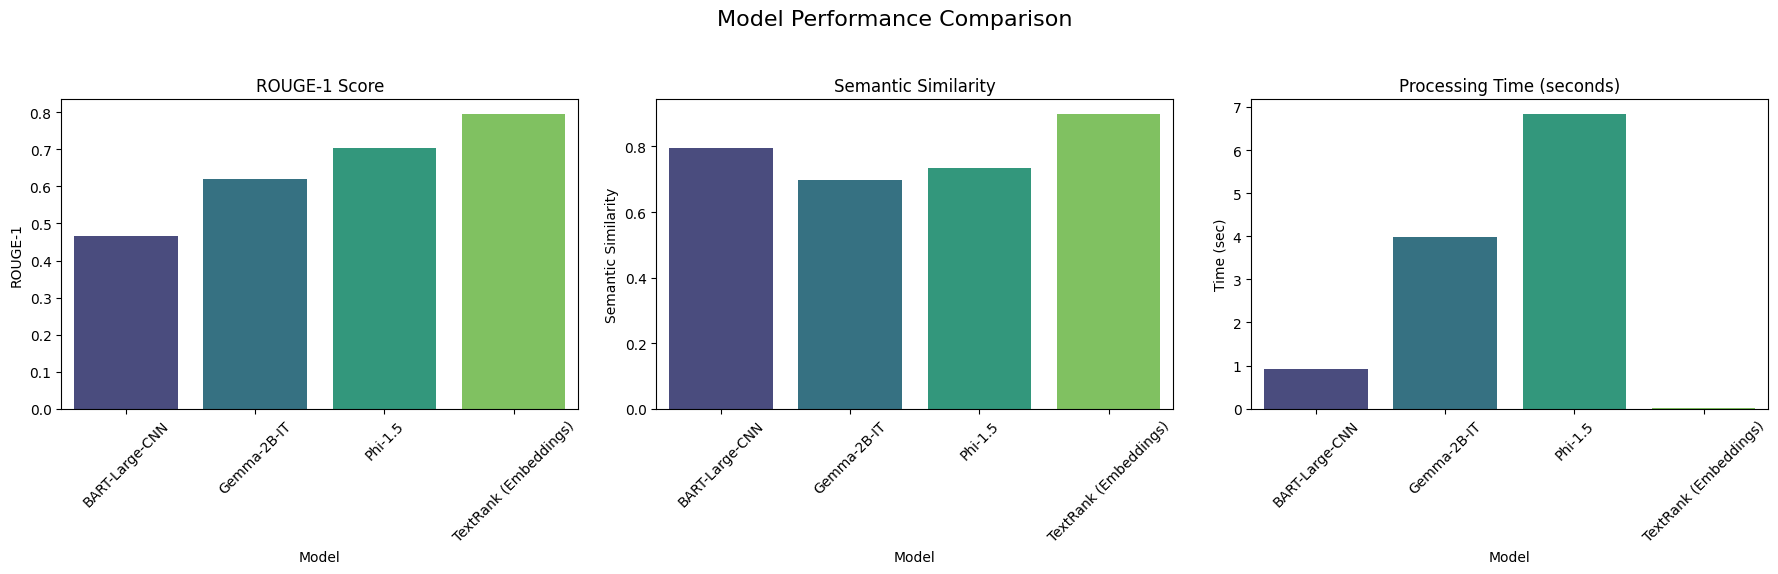

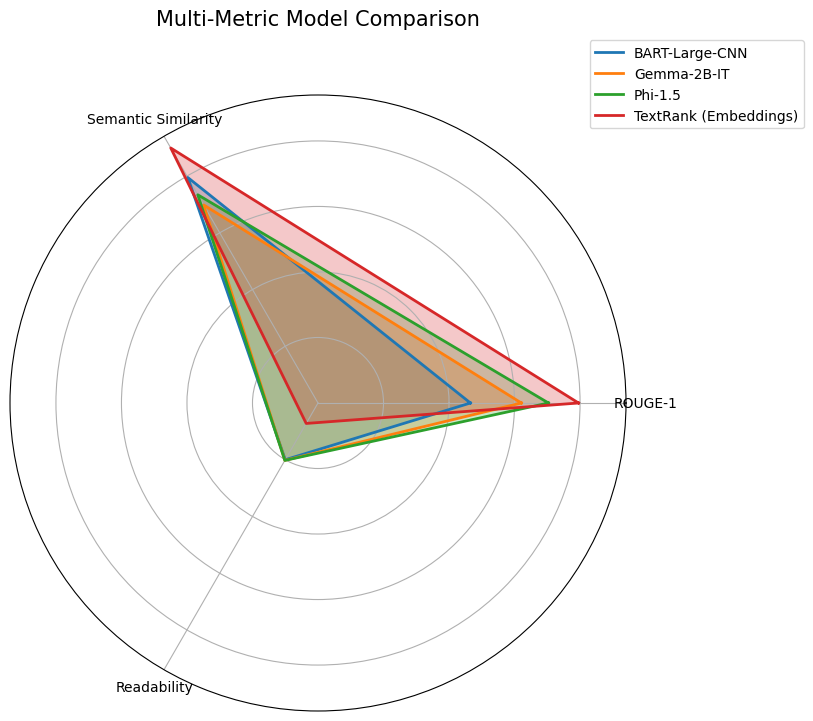

In [5]:


# --- NEW HELPER FUNCTION (Does not affect Section 4) ---
def summarize_bart_safe(text, max_len=200):
    """
    Handles BART summarization with dynamic length parameters to suppress
    the 'max_length' warning when the input text is short.
    It directly accesses the BART pipeline from the global MODELS dictionary.
    """
    input_words = len(text.split())

    # Calculate dynamic max_length: Half of input words, but not exceeding the default max_len (200)
    dynamic_max_len = max(10, min(max_len, int(input_words * 0.5)))

    # Calculate dynamic min_length: Quarter of input words, but not exceeding dynamic_max_len
    dynamic_min_len = min(dynamic_max_len, max(10, int(input_words * 0.25)))

    # BART handles longer input (up to 4096 tokens)
    return MODELS['bart']['summarizer'](
        text[:4096],
        max_length=dynamic_max_len,
        min_length=dynamic_min_len,
        do_sample=False
    )[0]['summary_text']


# --- 1. Define Sample Texts (10 texts, each approx 250 words) ---
sample_texts = [
    "The recent surge in artificial intelligence has profound implications for the global workforce. Experts predict that automation will displace millions of jobs in manufacturing and data processing sectors, while simultaneously creating new roles focused on AI development, maintenance, and ethical oversight. Governments and educational institutions are urged to invest heavily in reskilling and upskilling programs to prepare the population for this transition. The key challenge lies in ensuring that the economic benefits of AI are broadly shared and do not exacerbate existing inequalities. Governments must work with private industry to make this transition equitable. This global shift requires extensive policy coordination, international agreements on data governance, and a fundamental rethinking of social safety nets to support displaced workers. The ethical dilemmas surrounding autonomous decision-making in AI systems also necessitate new regulatory frameworks to protect human rights and ensure accountability, making this one of the most complex technological transformations in human history. The long-term societal changes brought about by AI are still largely unknown, prompting urgent calls for interdisciplinary research.",
    "Renewable energy sources like solar and wind power are critical components of the world's strategy to combat climate change. Unlike fossil fuels, which emit greenhouse gases, these sources produce electricity with a minimal carbon footprint. However, a major hurdle remains in energy storage, as solar and wind generation is intermittent. Developing cost-effective and scalable battery technology is essential for a complete global transition to a sustainable power grid. Many countries are subsidizing research and development to accelerate this process, focusing on utility-scale storage solutions. Furthermore, advances in geothermal and tidal energy are also being explored as reliable, baseload alternatives. The integration of smart grid technologies is crucial for managing the decentralized nature of renewable power generation, requiring significant investment in infrastructure upgrades and cybersecurity measures to protect the grid from increasingly sophisticated threats. This transition requires overcoming political inertia and massive infrastructure investment to ensure reliability and affordability for all consumers worldwide, regardless of geographical location.",
    "The human brain is arguably the most complex object in the known universe, consisting of billions of neurons that communicate through electrical and chemical signals. This intricate network is responsible for everything from basic involuntary functions to complex processes like consciousness, memory, and emotion. Neuroscientists use advanced imaging techniques like fMRI and EEG to map brain activity and understand how different regions interact. Continued research promises breakthroughs in treating neurological disorders such as Alzheimer's and Parkinson's disease, offering hope for millions worldwide. Recent studies have focused on neuroplasticity, revealing the brain's remarkable ability to reorganize itself by forming new neural connections throughout life. This understanding is key to developing personalized rehabilitation programs for stroke victims and individuals with traumatic brain injuries, pushing the boundaries of what is possible in cognitive recovery and mental health treatment. Understanding the intricacies of neural communication is essential for developing next-generation therapeutic strategies.",
    "A healthy diet is not merely about managing weight, but about providing the body with the necessary nutrients for optimal function. It includes a balanced intake of macronutrients (carbohydrates, proteins, fats) and micronutrients (vitamins and minerals). Processed foods, often high in sugar and unhealthy fats, contribute to a variety of chronic diseases. Embracing whole, unprocessed foods like fruits, vegetables, and lean proteins is fundamental to long-term health and well-being. Regular physical activity should also be combined with good nutrition for best results. Public health initiatives globally are targeting the reduction of sugar consumption and promoting plant-based diets rich in fiber. The impact of the gut microbiome on overall health, including mental well-being, is a rapidly expanding area of research, suggesting that dietary choices have far-reaching effects beyond physical appearance, influencing inflammation and immune system function across the lifespan. Nutritional education from an early age is vital for establishing lifelong healthy eating habits across all demographics and socio-economic groups.",
    "Quantum computing represents a revolutionary paradigm shift from classical computing. While classical bits store information as 0 or 1, a quantum bit (qubit) can exist in a superposition of both states simultaneously. This property, along with entanglement, allows quantum computers to perform certain calculations exponentially faster than any conventional machine. Currently, the technology is highly unstable and requires extremely low temperatures, but its eventual applications could transform fields like cryptography, material science, and drug discovery, opening up new scientific frontiers. Several governments and tech giants are in a race to achieve quantum supremacy, focusing efforts on developing more stable qubit architectures, such as superconducting circuits and trapped ions. The long-term security implications are also significant, as a large-scale quantum computer could theoretically break current public-key encryption methods, necessitating the rapid development of post-quantum cryptography standards. Research institutions are actively training the next generation of quantum engineers and physicists to lead this technological revolution in the coming decades.",
    "The great barrier reef, the world's largest coral reef system, is a breathtaking natural wonder stretching over 2,300 kilometers off the coast of Australia. It is home to an incredible diversity of marine life, including countless species of fish, sharks, sea turtles, and dolphins. Unfortunately, the reef is severely threatened by climate change, specifically ocean acidification and rising sea temperatures that cause coral bleaching. Conservation efforts are underway globally to reduce carbon emissions and protect this fragile ecosystem for future generations. Innovative techniques, such as developing heat-resistant coral strains and deploying automated underwater vehicles to monitor reef health, are being trialed with cautious optimism. Funding for marine park management and stricter regulations on coastal development and agricultural runoff are also vital to mitigating localized human impacts that compound the existential threat posed by global climate change, requiring urgent international cooperation to safeguard the biodiversity of the entire ecosystem. Protecting the reef is a litmus test for global environmental stewardship.",
    "Reading fiction is a powerful exercise for the human mind, often resulting in increased empathy and improved theory of mind. When we immerse ourselves in a novel, we are forced to see the world from different characters' perspectives, expanding our emotional intelligence. Studies show that people who regularly read fiction are better at understanding and predicting the actions of others in real-life social situations. Beyond empathy, reading also improves vocabulary, concentration, and analytical skills, which are beneficial in professional life. The cognitive benefits extend to improved memory and reduced stress levels, making it a valuable tool for lifelong learning and mental resilience. Literary scholars often explore how fiction shapes cultural narratives and moral reasoning, suggesting a deeper societal role for storytelling than mere entertainment. The choice of reading material, from classic literature to contemporary speculative fiction, can significantly influence an individual's worldview and critical thinking abilities. Encouraging reading culture is a key educational objective.",
    "Microplastics, tiny fragments of plastic less than 5mm long, have become a pervasive global pollutant found everywhere from the deepest oceans to the highest mountains. They originate from the breakdown of larger plastic items and pose a threat to marine life, which often mistake them for food. Researchers are actively studying the long-term effects of microplastics on human health, especially as they enter the food chain. Finding sustainable alternatives to single-use plastics and improving waste management systems are urgent priorities for environmental health. The challenge is magnified by the complexity of plastics recycling, with much of the world's plastic waste still ending up in landfills or leaking into natural environments. Scientists are developing innovative enzyme-based solutions and pyrolysis technologies to efficiently break down different types of plastic polymers, offering hope for a circular economy. Global legislation restricting unnecessary plastic packaging is gaining momentum, pushing industries toward bio-degradable or infinitely reusable materials. Consumer behavior changes are equally important in mitigating this widespread environmental crisis.",
    "The concept of cryptocurrency, decentralized digital money secured by cryptography, was popularized by the introduction of Bitcoin in 2009. Unlike traditional currencies, it is not controlled by any single bank or government, operating instead on a distributed ledger technology called blockchain. While initially met with skepticism, cryptocurrencies have gained mainstream acceptance as an asset class and a method of payment. However, they remain highly volatile and face significant regulatory challenges globally, particularly regarding consumer protection. Central banks are exploring the development of their own digital currencies (CBDCs) to modernize payment systems and maintain monetary control in the face of decentralized competition. The energy consumption associated with proof-of-work cryptocurrencies is also a major environmental concern, driving a shift towards more energy-efficient proof-of-stake mechanisms. The future of global finance is increasingly hybrid, blending traditional institutions with decentralized technology and requiring new legal frameworks to ensure market stability and prevent illicit financial activities.",
    "Plate tectonics is the scientific theory that Earth's outer layer is divided into several large plates that slowly move over the mantle. This movement is the driving force behind earthquakes, volcanic eruptions, and the formation of mountain ranges. The plates interact at their boundaries: they can slide past, collide, or separate. The theory revolutionized geology, explaining many phenomena and providing a unified framework for understanding the planet's dynamic surface and its geological history. Advances in GPS technology and seismic monitoring allow scientists to measure plate movements with unprecedented accuracy, improving hazard prediction models for communities located near active fault lines and subduction zones. The slow process of continental drift has shaped not only geology but also global climate and the evolution of life on Earth, linking deep-time geological processes to contemporary ecological distribution and long-term environmental stability. Continued research into mantle convection provides critical clues about the fundamental forces driving this planetary mechanism."
]

# --- 2. Batch Processing Function ---

def run_sample_batch_test(texts):
    """
    Runs a batch of texts through all specified Abstractive and Extractive models,
    calculates metrics, and displays the full results table and charts.
    """
    # Define models to test based on the notebook's setup
    ABSTRACTIVE_KEYS = ['bart', 'gemma', 'phi']
    EXTRACTIVE_KEYS = ['embedding', 'gemma', 'phi'] # 'embedding' is TextRank

    print(f"--- Running Batch Test on {len(texts)} Samples ---")
    batch_metrics = []

    # --- STEP 1: PRINT ALL ABSTRACTIVE AND EXTRACTIVE SUMMARIES (User Request) ---
    print("\n=============================================")
    print(f" ABSTRACTIVE & EXTRACTIVE SUMMARIES for All 10 Samples")
    print("=============================================")

    # Generate and print Abstractive Summaries
    for model_key in ABSTRACTIVE_KEYS:
        model_name = MODELS[model_key]['name']

        # --- FIX: SKIP PRINTING FOR PHI-1.5 ABSTRACTIVE SUMMARIES ---
        if model_key == 'phi':
            print(f"\n--- ABSTRACTIVE MODEL: {model_name} (Printing Skipped as requested due to non-standard output) ---")
            continue
        # -------------------------------------------------------------------

        print(f"\n--- ABSTRACTIVE MODEL: {model_name} ---")

        for i, text in enumerate(texts):
            try:
                start_time = time.time()
                # Use the NEW safe function for BART, otherwise use the old one
                if model_key == 'bart':
                    summary = summarize_bart_safe(text)
                else:
                    summary = summarize_abstractive(text, model_key)

                proc_time = time.time() - start_time

                print(f"Sample {i+1} (Words: {len(summary.split())} | Time: {proc_time:.2f}s): {summary}")
                print("-" * 20)
            except Exception as e:
                error_msg = f"Summarization Error: {e}"
                print(f"Sample {i+1}: {error_msg}")
                print("-" * 20)

    # Generate and print Extractive Summaries
    for model_key in EXTRACTIVE_KEYS:
        model_name = MODELS[model_key]['name']
        print(f"\n--- EXTRACTIVE MODEL: {model_name} ---")

        for i, text in enumerate(texts):
            try:
                start_time = time.time()
                # Use the existing summarize_extractive from Section 4
                summary = summarize_extractive(text, model_key, num_sentences=5)

                proc_time = time.time() - start_time

                # Print extractive as single paragraph, removing internal newlines
                print(f"Sample {i+1} (Words: {len(summary.split())} | Time: {proc_time:.2f}s): {summary.replace('\n', ' ')}")
                print("-" * 20)
            except Exception as e:
                error_msg = f"Summarization Error: {e}"
                print(f"Sample {i+1}: {error_msg}")
                print("-" * 20)

    print("=============================================\n")


    # --- STEP 2: RUN ALL TESTS AND COLLECT METRICS ---

    # 1. Run Abstractive Models (BART, Gemma, Phi) - ALL MODELS ARE RUN HERE
    print(f"\n[Abstractive Test]: Collecting Metrics for {', '.join([MODELS[k]['name'] for k in ABSTRACTIVE_KEYS])}...")
    for model_key in ABSTRACTIVE_KEYS:
        model_name = MODELS[model_key]['name']
        for i, text in enumerate(texts):
            sample_key = f'Sample {i+1}'
            start_time = time.time()
            try:
                # Use the NEW safe function for BART
                if model_key == 'bart':
                    summary = summarize_bart_safe(text)
                else:
                    summary = summarize_abstractive(text, model_key)

                proc_time = time.time() - start_time
                metrics = calculate_metrics(summary, text, proc_time)
                metrics.update({'Model': model_name, 'File': sample_key, 'Type': 'Abstractive', 'Summary Text': summary })
                batch_metrics.append(metrics)
                #print(f"✅ {model_name} on {sample_key} metrics collected ({metrics['Time (sec)']:.2f}s)")
            except Exception as e:
                batch_metrics.append({'Model': model_name, 'File': sample_key, 'Type': 'Abstractive', 'Summary Text': f"Error: {e}", "Time (sec)": 0.0, "ROUGE-1": 0.0, "Semantic Similarity": 0.0, "Readability": 0.0, "Length (words)": 0, "Compression": "0.0%"})
                print(f"🛑 Error processing {sample_key} with {model_name}: {e}")

    # 2. Run Extractive Models (TextRank, Gemma, Phi)
    print(f"\n[Extractive Test]: Collecting Metrics for {', '.join([MODELS[k]['name'] for k in EXTRACTIVE_KEYS])}...")
    for model_key in EXTRACTIVE_KEYS:
        model_name = MODELS[model_key]['name']
        for i, text in enumerate(texts):
            sample_key = f'Sample {i+1}'
            start_time = time.time()
            try:
                summary = summarize_extractive(text, model_key, num_sentences=5)
                proc_time = time.time() - start_time
                metrics = calculate_metrics(summary, text, proc_time)
                metrics.update({'Model': model_name, 'File': sample_key, 'Type': 'Extractive', 'Summary Text': summary })
                batch_metrics.append(metrics)
                #print(f"✅ {model_name} on {sample_key} metrics collected ({metrics['Time (sec)']:.2f}s)")
            except Exception as e:
                batch_metrics.append({'Model': model_name, 'File': sample_key, 'Type': 'Extractive', 'Summary Text': f"Error: {e}", "Time (sec)": 0.0, "ROUGE-1": 0.0, "Semantic Similarity": 0.0, "Readability": 0.0, "Length (words)": 0, "Compression": "0.0%"})
                print(f"🛑 Error processing {sample_key} with {model_name}: {e}")

    # --- 3. Display Results ---

    df_results = pd.DataFrame(batch_metrics)

    display(HTML("<hr><h2>Batch Test Results Overview (Detailed Table)</h2>"))
    display(df_results.drop(columns=['Summary Text']))

    display(HTML("<h3>Comparison Charts (Aggregated by Model)</h3>"))
    df_aggregated = df_results.drop(columns=['Summary Text', 'File', 'Type', 'Compression']).groupby('Model').mean().reset_index()

    plot_output_bar = widgets.Output()
    plot_output_radar = widgets.Output()

    with plot_output_bar:
        display(create_bar_charts(df_aggregated))
    with plot_output_radar:
        display(create_radar_chart(df_aggregated))

    display(widgets.VBox([plot_output_bar, plot_output_radar]))

    display(HTML("<h3>Full Summary Output (For Qualitative Review - includes Extractive)</h3>"))
    display(df_results[['Model', 'File', 'Type', 'Compression', 'Summary Text']])

    print("\n--- Batch Test Complete ---")


# --- 4. Execute the function ---
run_sample_batch_test(sample_texts)

## Section A: Summarize with All Models (Prompt UI)
This UI is simplified for quick comparisons. Just paste your text, choose the summary type, and it will automatically run all compatible models.



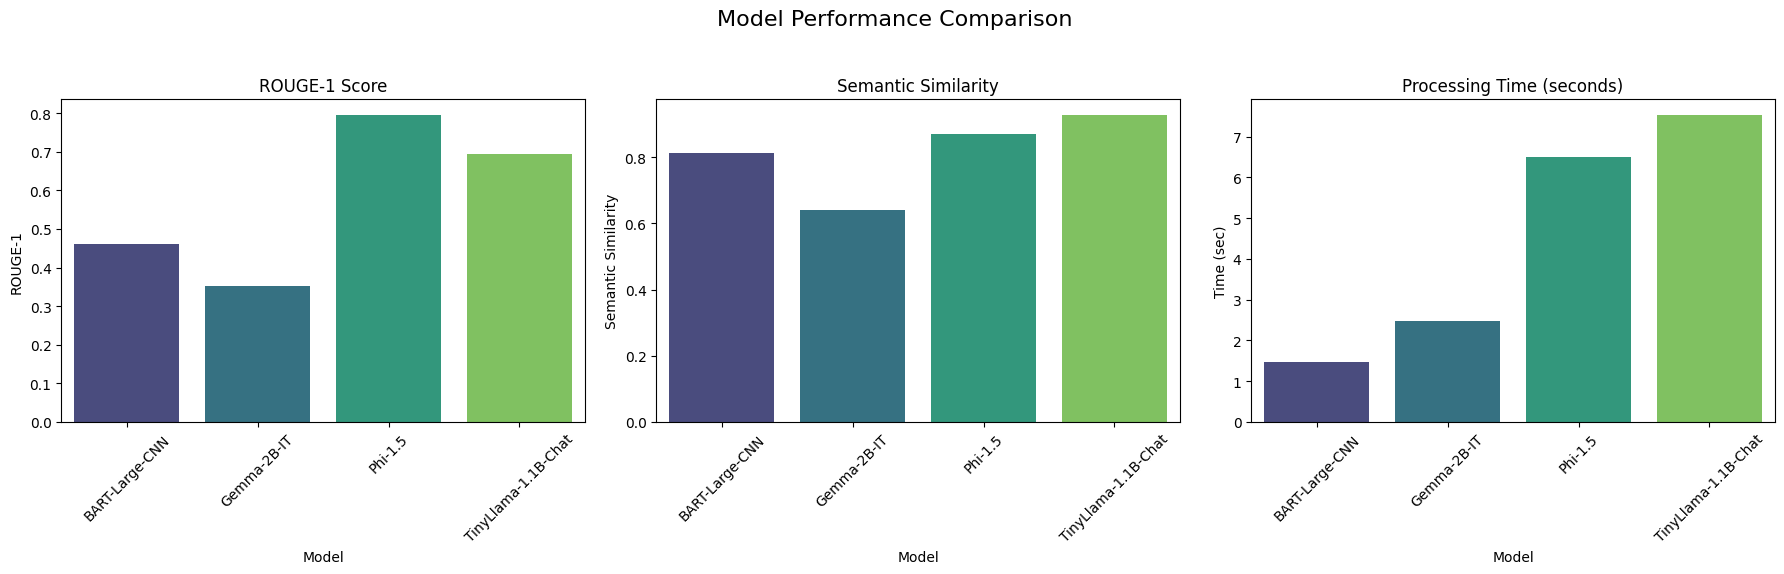

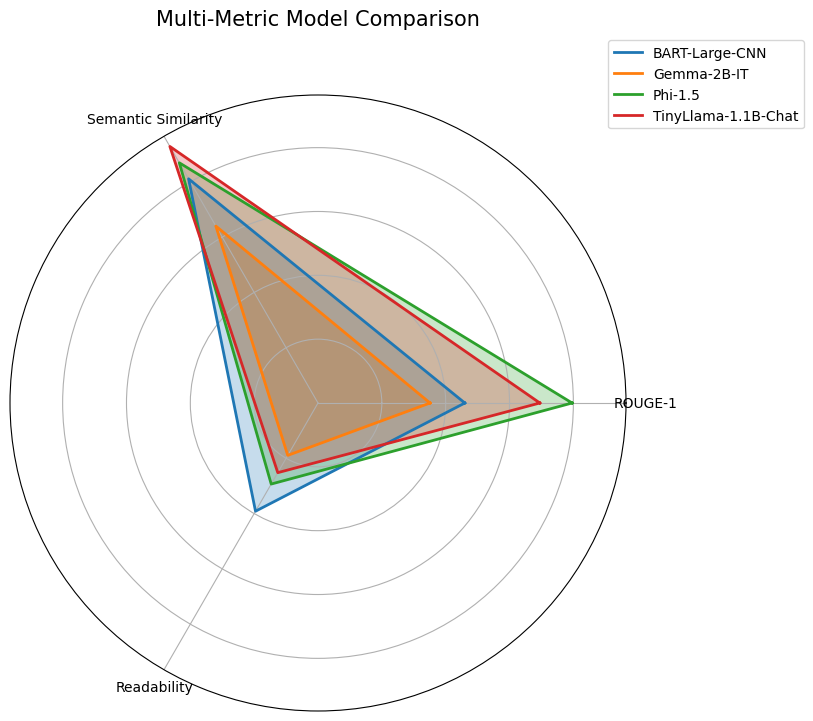

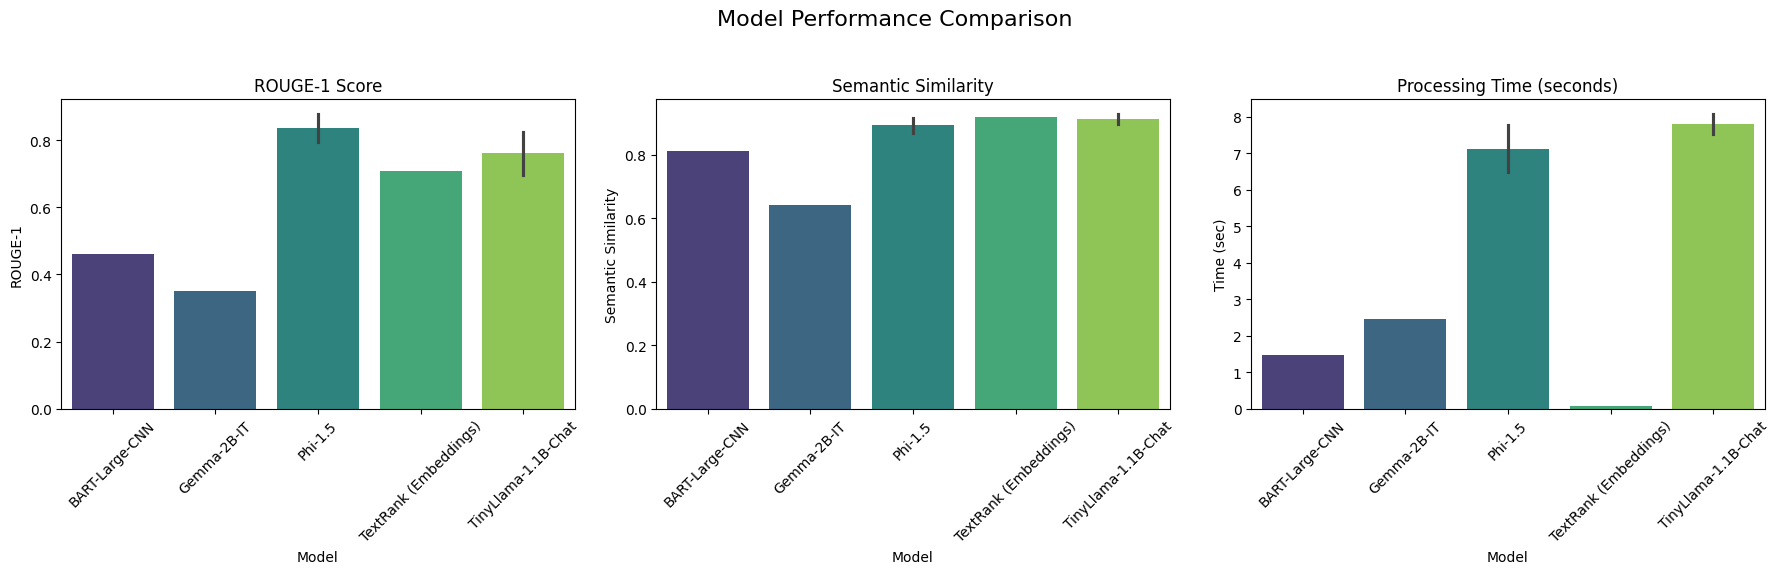

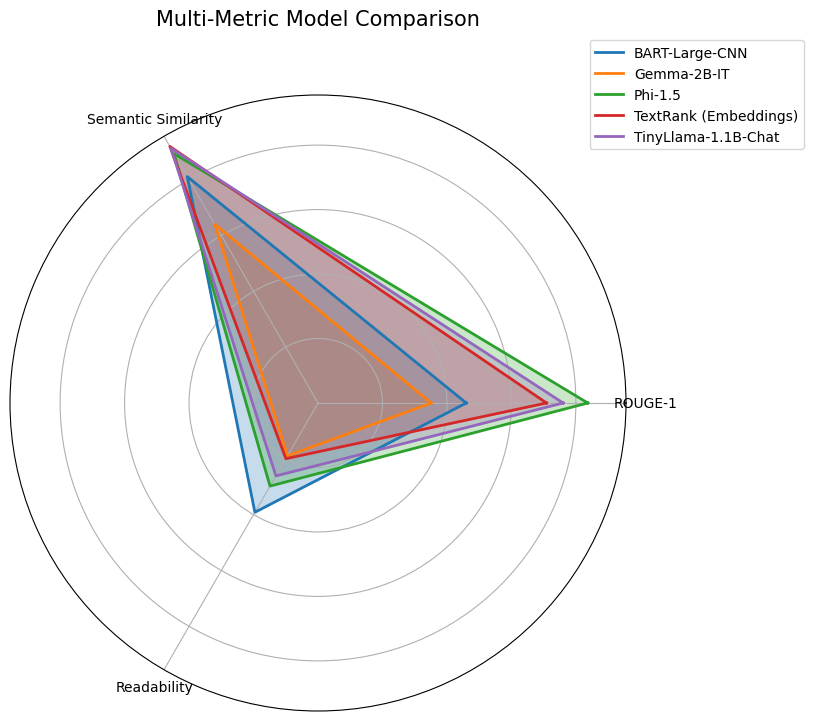

In [ ]:
# --- SECTION A: RUN ALL MODELS UI ---

# --- State and Choices ---
metrics_history_all = []
#abstractive_model_choices = {MODELS[k]['name']: k for k in ['tinyllama', 'phi', 'bart']}
abstractive_model_choices = {MODELS[k]['name']: k for k in ['tinyllama', 'phi', 'gemma', 'bart']}
extractive_model_choices = {MODELS[k]['name']: k for k in ['tinyllama', 'phi', 'embedding']}

# --- UI Widget Definitions ---
header_all = widgets.HTML("<h2>Section A: Summarize with All Models</h2><p>Paste text and choose a summary type. The system will automatically run all compatible models for a full comparison.</p>")
prompt_input_all = widgets.Textarea(placeholder='Paste your text here to summarize...', layout={'height': '200px', 'width': '99%'})
summary_type_all = widgets.RadioButtons(options=['Abstractive', 'Extractive'], value='Abstractive', description='Summ. Type:')
generate_button_all = widgets.Button(description='🚀 Generate All Summaries', button_style='primary', icon='cogs')
clear_button_all = widgets.Button(description='🧹 Clear Outputs', button_style='warning', icon='trash')

# --- Output Widget Definitions ---
summary_output_all = widgets.Output(layout={'height': '400px', 'border': '1px solid #ccc', 'padding': '10px', 'overflow': 'scroll'})
metrics_table_output_all = widgets.Output()
bar_plot_output_all = widgets.Output()
radar_plot_output_all = widgets.Output()
output_accordion_all = widgets.Accordion(children=[metrics_table_output_all, bar_plot_output_all, radar_plot_output_all])
output_accordion_all.set_title(0, '📊 Metrics Table'); output_accordion_all.set_title(1, '📈 Bar Charts'); output_accordion_all.set_title(2, '✨ Radar Plot')

# --- Event Handlers ---
def on_generate_button_clicked_all(b):
    generate_button_all.disabled = True; generate_button_all.description = "Processing..."
    original_text, s_type = prompt_input_all.value, summary_type_all.value
    if not original_text.strip():
        with summary_output_all: print("⚠️ Please paste text to summarize.")
        generate_button_all.disabled = False; generate_button_all.description = "🚀 Generate All Summaries"; return

    s_keys = list(abstractive_model_choices.values()) if s_type == 'Abstractive' else list(extractive_model_choices.values())

    with summary_output_all: display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))
    for model_key in s_keys:
        model_name = MODELS[model_key]['name']
        with summary_output_all: print(f"⏳ Summarizing with {model_name}...")
        start_time = time.time()
        summary = summarize_abstractive(original_text, model_key) if s_type == "Abstractive" else summarize_extractive(original_text, model_key)
        proc_time = time.time() - start_time
        with summary_output_all: display(HTML(f"<h3>Summary from {model_name}</h3><p>{summary}</p>"))
        metrics = calculate_metrics(summary, original_text, proc_time)
        metrics.update({'Model': model_name, 'File': 'Pasted Text', 'Type': s_type})
        metrics_history_all.append(metrics)

    df = pd.DataFrame(metrics_history_all)
    with metrics_table_output_all: metrics_table_output_all.clear_output(wait=True); display(df)
    with bar_plot_output_all: bar_plot_output_all.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_all: radar_plot_output_all.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_all.disabled = False; generate_button_all.description = "🚀 Generate All Summaries"

def on_clear_button_clicked_all(b):
    global metrics_history_all; metrics_history_all = []
    summary_output_all.clear_output(); metrics_table_output_all.clear_output()
    bar_plot_output_all.clear_output(); radar_plot_output_all.clear_output()
    prompt_input_all.value = ""
    with summary_output_all: print("Outputs cleared.")

generate_button_all.on_click(on_generate_button_clicked_all)
clear_button_all.on_click(on_clear_button_clicked_all)

# --- Assemble and Display UI with FIXED Layout ---
input_controls_all = widgets.VBox(
    [prompt_input_all, summary_type_all, widgets.HBox([generate_button_all, clear_button_all])],
    layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px')
)
output_area_all = widgets.VBox(
    [summary_output_all, output_accordion_all],
    layout=widgets.Layout(width='65%', padding='10px')
)
app_all = widgets.VBox([header_all, widgets.HBox([input_controls_all, output_area_all])])

display(app_all)

## Section B: Summarize with Specific Models (Checkbox UI)
This UI gives you fine-grained control, allowing you to select exactly which models you want to run using checkboxes.



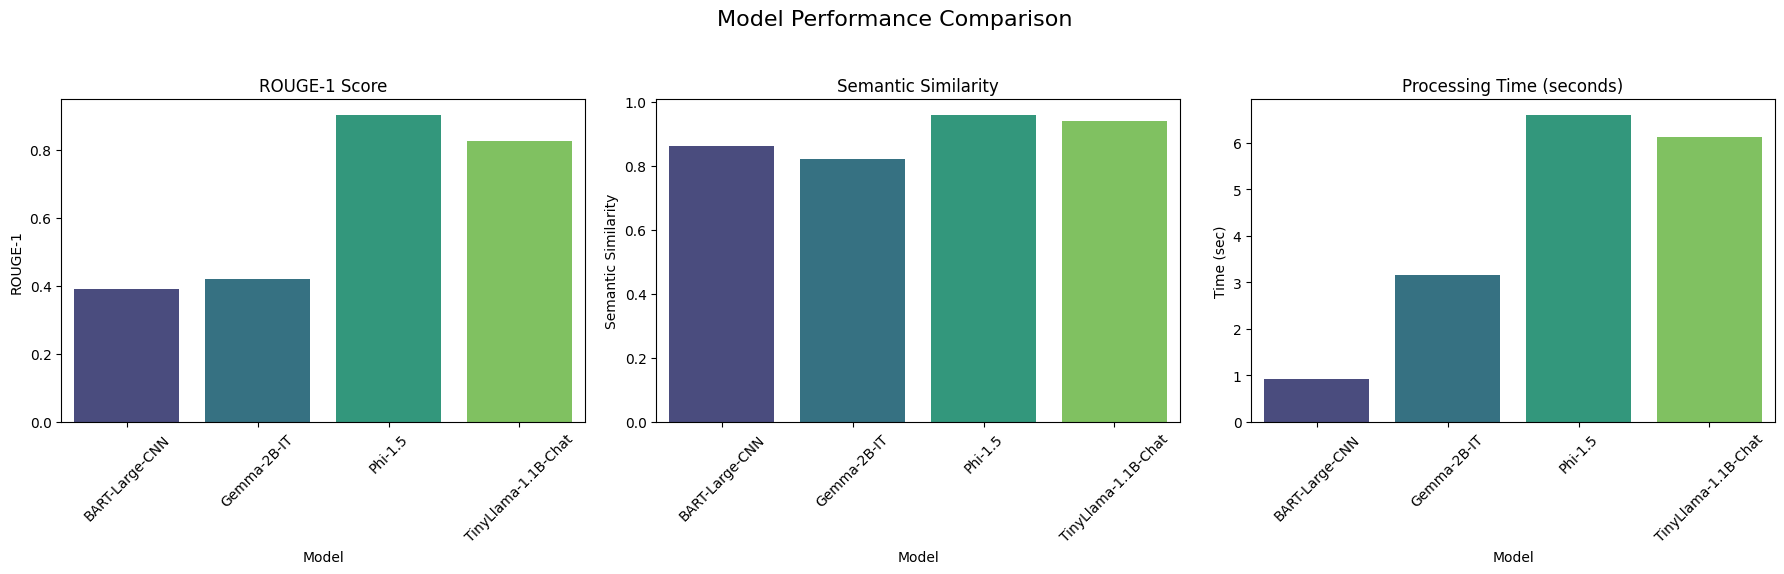

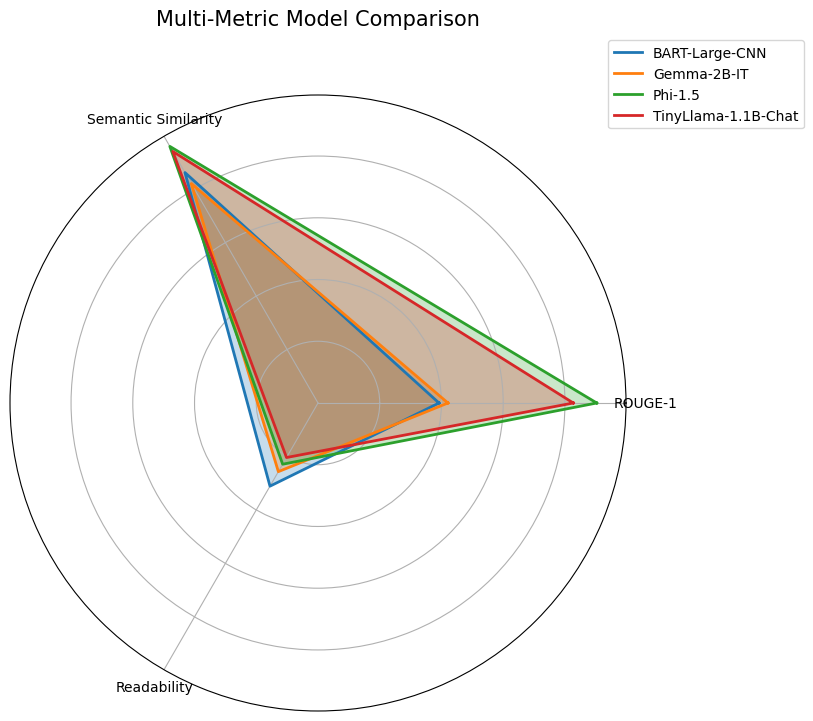

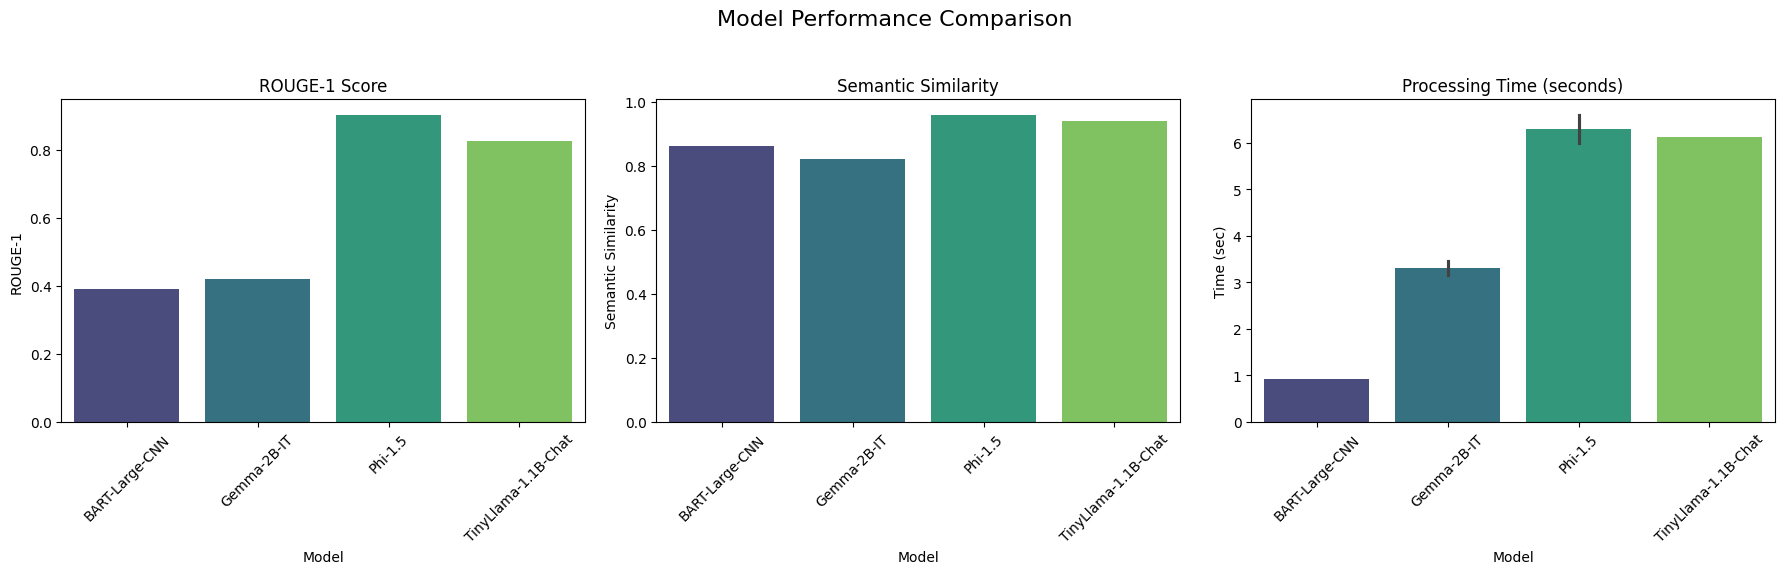

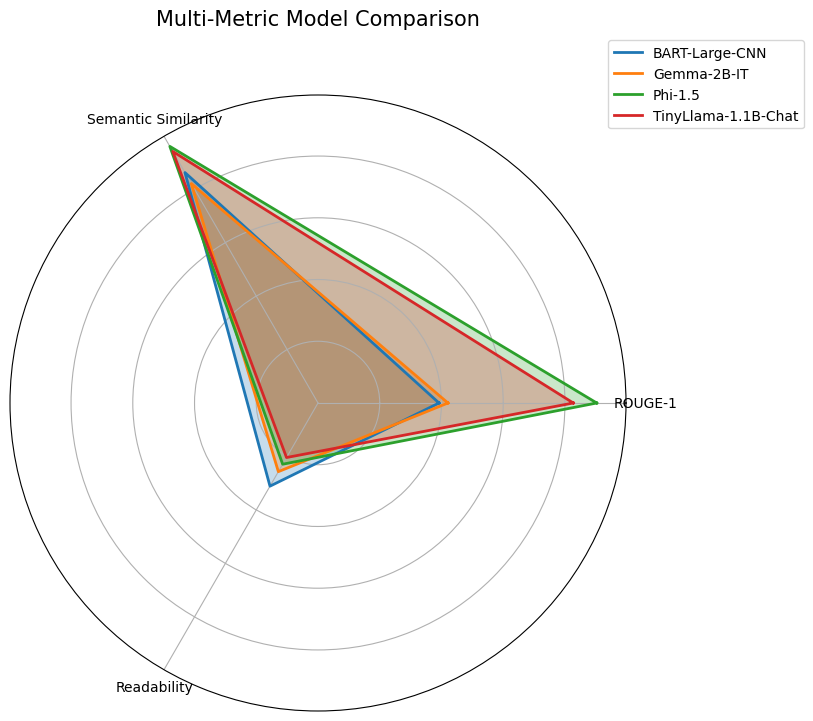

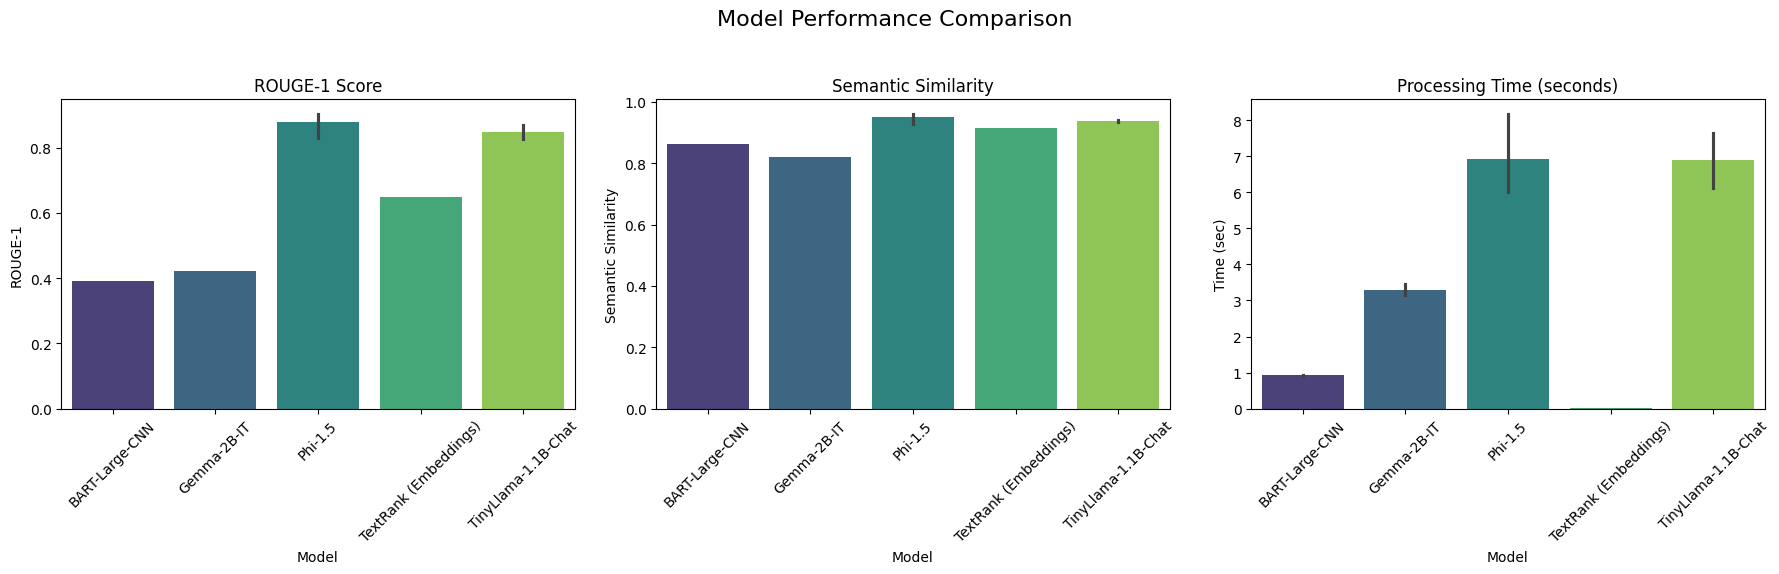

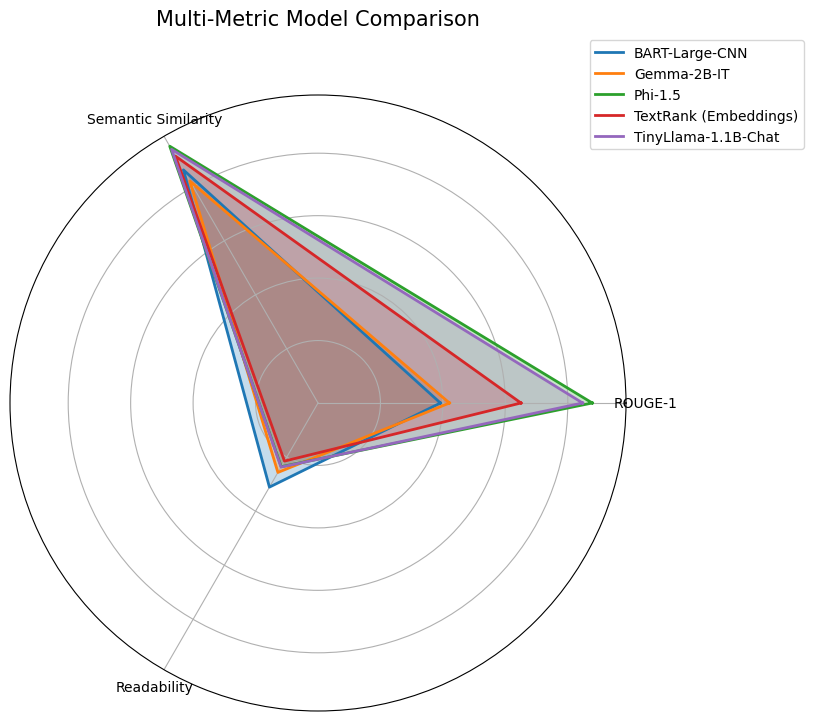

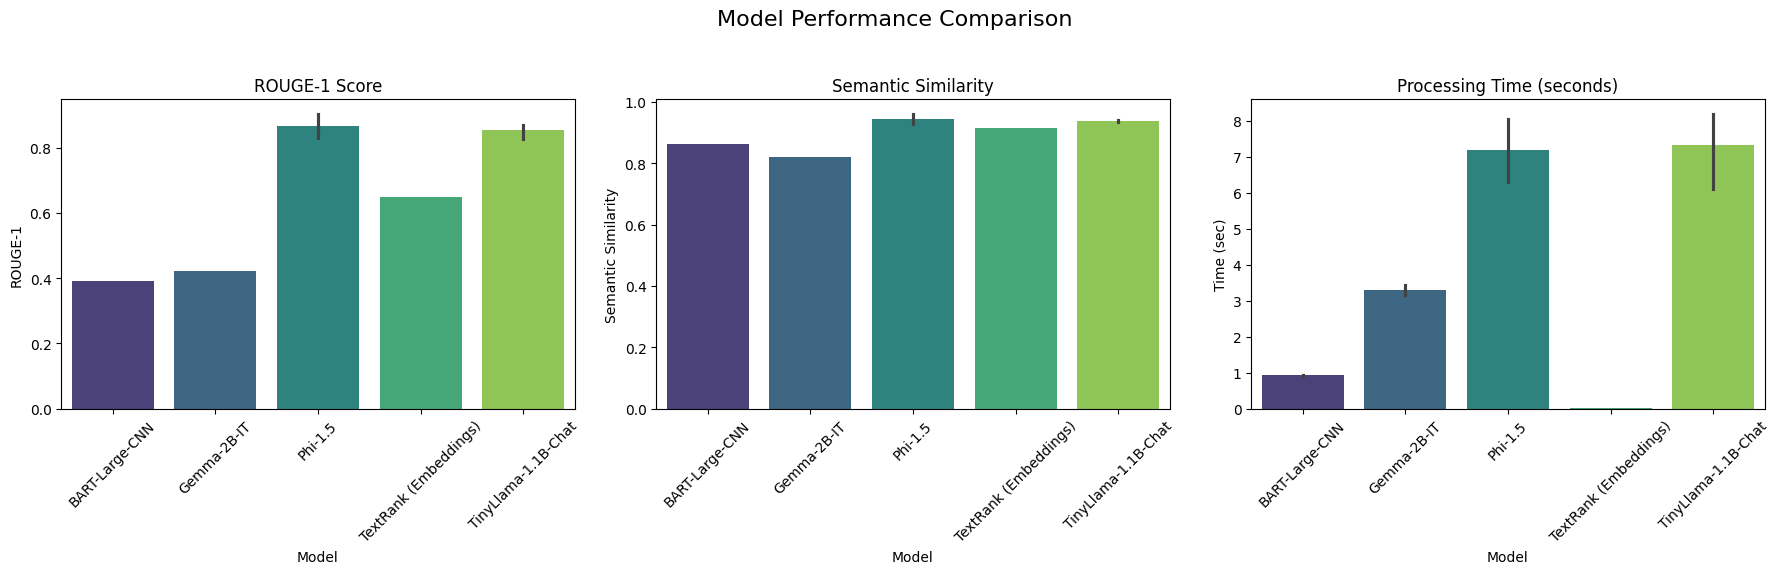

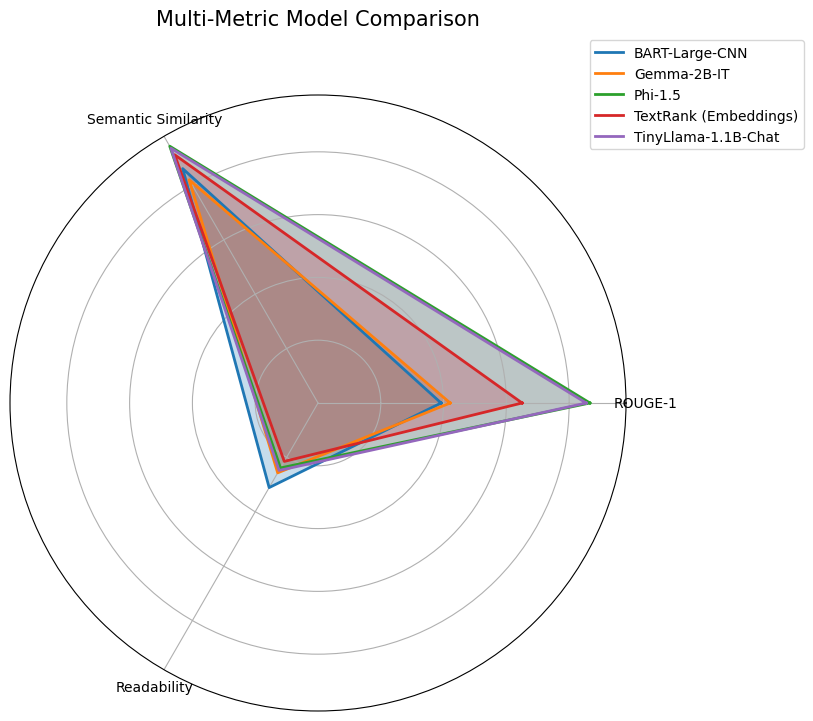

In [ ]:
# --- SECTION B: SELECT SPECIFIC MODELS UI ---

# --- State and Choices ---
metrics_history_specific = []
# (Choices are reused from Section A)

# --- UI Widget Definitions ---
header_specific = widgets.HTML("<h2>Section B: Summarize with Specific Models</h2><p>Paste text, choose a summary type, and check the specific models you want to run.</p>")
prompt_input_specific = widgets.Textarea(placeholder='Paste your text here to summarize...', layout={'height': '200px', 'width': '99%'})
summary_type_specific = widgets.RadioButtons(options=['Abstractive', 'Extractive'], value='Abstractive', description='Summ. Type:')
model_checkboxes_out = widgets.Output() # A container for our dynamic checkboxes
checkboxes = {}
generate_button_specific = widgets.Button(description='🚀 Generate Summaries', button_style='primary', icon='cogs')
clear_button_specific = widgets.Button(description='🧹 Clear Outputs', button_style='warning', icon='trash')

# --- Output Widget Definitions ---
summary_output_specific = widgets.Output(layout={'height': '400px', 'border': '1px solid #ccc', 'padding': '10px', 'overflow': 'scroll'})
metrics_table_output_specific = widgets.Output()
bar_plot_output_specific = widgets.Output()
radar_plot_output_specific = widgets.Output()
output_accordion_specific = widgets.Accordion(children=[metrics_table_output_specific, bar_plot_output_specific, radar_plot_output_specific])
output_accordion_specific.set_title(0, '📊 Metrics Table'); output_accordion_specific.set_title(1, '📈 Bar Charts'); output_accordion_specific.set_title(2, '✨ Radar Plot')

# --- Event Handlers ---
def update_checkboxes(s_type):
    global checkboxes; checkboxes = {}
    choices = abstractive_model_choices if s_type == 'Abstractive' else extractive_model_choices
    with model_checkboxes_out:
        model_checkboxes_out.clear_output(wait=True)
        for name, key in choices.items():
            checkboxes[key] = widgets.Checkbox(value=True, description=name)
        display(widgets.VBox(list(checkboxes.values())))

def on_generate_button_clicked_specific(b):
    generate_button_specific.disabled = True; generate_button_specific.description = "Processing..."
    original_text, s_type = prompt_input_specific.value, summary_type_specific.value
    s_keys = [key for key, cb in checkboxes.items() if cb.value]

    if not original_text.strip() or not s_keys:
        with summary_output_specific: print("⚠️ Please paste text and check at least one model.")
        generate_button_specific.disabled = False; generate_button_specific.description = "🚀 Generate Summaries"; return

    with summary_output_specific: display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))
    for model_key in s_keys:
        model_name = MODELS[model_key]['name']
        with summary_output_specific: print(f"⏳ Summarizing with {model_name}...")
        start_time = time.time()
        summary = summarize_abstractive(original_text, model_key) if s_type == "Abstractive" else summarize_extractive(original_text, model_key)
        proc_time = time.time() - start_time
        with summary_output_specific: display(HTML(f"<h3>Summary from {model_name}</h3><p>{summary}</p>"))
        metrics = calculate_metrics(summary, original_text, proc_time)
        metrics.update({'Model': model_name, 'File': 'Pasted Text', 'Type': s_type})
        metrics_history_specific.append(metrics)

    df = pd.DataFrame(metrics_history_specific)
    with metrics_table_output_specific: metrics_table_output_specific.clear_output(wait=True); display(df)
    with bar_plot_output_specific: bar_plot_output_specific.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_specific: radar_plot_output_specific.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_specific.disabled = False; generate_button_specific.description = "🚀 Generate Summaries"

def on_clear_button_clicked_specific(b):
    global metrics_history_specific; metrics_history_specific = []
    summary_output_specific.clear_output(); metrics_table_output_specific.clear_output()
    bar_plot_output_specific.clear_output(); radar_plot_output_specific.clear_output()
    prompt_input_specific.value = ""
    with summary_output_specific: print("Outputs cleared.")

def on_summary_type_change_specific(change):
    update_checkboxes(change.new)

generate_button_specific.on_click(on_generate_button_clicked_specific)
clear_button_specific.on_click(on_clear_button_clicked_specific)
summary_type_specific.observe(on_summary_type_change_specific, names='value')

# --- Assemble and Display UI with FIXED Layout ---
input_controls_specific = widgets.VBox(
    [prompt_input_specific, summary_type_specific, widgets.Label("Select Models:"), model_checkboxes_out, widgets.HBox([generate_button_specific, clear_button_specific])],
    layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px')
)
output_area_specific = widgets.VBox(
    [summary_output_specific, output_accordion_specific],
    layout=widgets.Layout(width='65%', padding='10px')
)
app_specific = widgets.VBox([header_specific, widgets.HBox([input_controls_specific, output_area_specific])])

# Initial population of checkboxes
update_checkboxes('Abstractive')

display(app_specific)